In [1]:
#匯入套件與設定環境
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import IPython.display as ipd
import ipywidgets

787 613


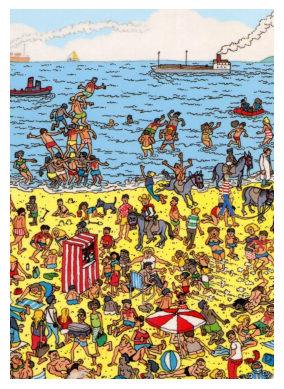

In [2]:
#讀取圖片與前處理(固定圖片尺寸，將威利合成到背景中)
BG_WIDTH = 1000
BG_HEIGHT = 1400
WALDO_WIDTH = 80
WALDO_HEIGHT = 180

#從Github連結下載圖片
bg_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/bg07.jpg"
bg_response = requests.get(bg_url)
bg_array = np.frombuffer(bg_response.content, np.uint8)
bg = cv2.imdecode(bg_array, cv2.IMREAD_COLOR)

waldo_url = "https://raw.githubusercontent.com/Zong0120/Where_is_Waldo/main/waldo.png"
waldo_response = requests.get(waldo_url)
waldo_array = np.frombuffer(waldo_response.content, np.uint8)
waldo = cv2.imdecode(waldo_array, cv2.IMREAD_UNCHANGED)

def generate_sample_image():
    #背景
    bg_resized = cv2.resize(bg, (BG_WIDTH, BG_HEIGHT))
    bg_rgb = cv2.cvtColor(bg_resized, cv2.COLOR_BGR2RGB)

    #威利
    waldo_resized = cv2.resize(waldo, (WALDO_WIDTH, WALDO_HEIGHT))
    waldo_rgb = cv2.cvtColor(waldo_resized[:, :, :3], cv2.COLOR_BGR2RGB)
    alpha_mask = waldo_resized[:, :, 3] / 255.0  # 取出Alpha通道並正規化到0-1

    #隨機產生waldo出現的座標，避免超出bg範圍
    col_range = (0, BG_WIDTH - WALDO_WIDTH)
    row_range = (0, BG_HEIGHT - WALDO_HEIGHT)
    col = np.random.randint(*col_range)
    row = np.random.randint(*row_range)

    #alpha_mask為0，表示完全透明，背景不變
    for c in range(3):
        bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c] = (
            alpha_mask * waldo_rgb[:, :, c] +
            (1 - alpha_mask) * bg_rgb[row:row+WALDO_HEIGHT, col:col+WALDO_WIDTH, c]
        )

    return bg_rgb, (col, row)

#測試函式
bg_rgb, (col, row) = generate_sample_image()
plt.imshow(bg_rgb)
plt.axis("off")
print(col, row)
plt.show()

787 613


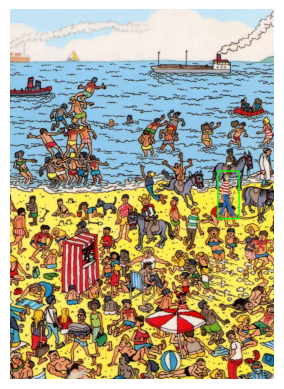

In [3]:
#繪製邊界框(正確答案為綠色外框，偵測結果為紅色外框)
def plot_bounding_box(image, ground_truth_pos, prediction_pos = None):

  cv2.rectangle(image, (ground_truth_pos[0], ground_truth_pos[1]),
             (ground_truth_pos[0] + WALDO_WIDTH, ground_truth_pos[1] + WALDO_HEIGHT),
             (0, 255, 0), 3)
  if prediction_pos is not None:
    cv2.rectangle(image, (prediction_pos[0], prediction_pos[1]),
               (prediction_pos[0] + WALDO_WIDTH, prediction_pos[1] + WALDO_HEIGHT),
               (255, 0, 0), 3)
  return image

#測試函式
image = plot_bounding_box(bg_rgb, (col, row))
plt.imshow(image)
plt.axis("off")
print(col, row)
plt.show()

In [4]:
#產生訓練圖片
def generate_data(batch_size = 16):

  while True:
    batch = np.zeros((batch_size, BG_HEIGHT, BG_WIDTH, 3))
    bounding_box = np.zeros((batch_size, 2))

    for i in range(batch_size):
      sample_image, pos = generate_sample_image()
      batch[i] = sample_image / 255 #正規化
      bounding_box[i, 0] = pos[0]
      bounding_box[i, 1] = pos[1]

    yield batch, bounding_box

#測試函式
train_data = generate_data()
batch, bounding_box = next(train_data) #產生一個批次的訓練資料(16組的圖片和二維座標)
print(batch.shape)
print(bounding_box.shape)

(16, 1400, 1000, 3)
(16, 2)


In [5]:
#模型評估指標，平均IoU
def mean_iou(y_true, y_pred):

  y_true = tf.cast(y_true, tf.float32)  #確保 y_true 是 float32
  y_pred = tf.cast(y_pred, tf.float32)  #確保 y_pred 是 float32

  #取得預測框的座標
  pred_x_min, pred_y_min = y_pred[:, 0], y_pred[:, 1]
  pred_x_max = pred_x_min + WALDO_WIDTH
  pred_y_max = pred_y_min + WALDO_HEIGHT

  #取得真實框的座標
  true_x_min, true_y_min = y_true[:, 0], y_true[:, 1]
  true_x_max = true_x_min + WALDO_WIDTH
  true_y_max = true_y_min + WALDO_HEIGHT

  #計算交集區域
  x1 = tf.maximum(true_x_min, pred_x_min)
  y1 = tf.maximum(true_y_min, pred_y_min)
  x2 = tf.minimum(true_x_max, pred_x_max)
  y2 = tf.minimum(true_y_max, pred_y_max)

  inter_width = tf.maximum(x2 - x1, 0)
  inter_height = tf.maximum(y2 - y1, 0)
  inter_area = inter_width * inter_height

  #計算聯集區域
  true_area = WALDO_WIDTH * WALDO_HEIGHT
  pred_area = WALDO_WIDTH * WALDO_HEIGHT
  union_area = true_area + pred_area - inter_area

  #計算IoU，避免除以0
  iou = inter_area / tf.maximum(union_area, tf.keras.backend.epsilon())

  #若預測框超出影像範圍，則IoU = 0
  out_of_bounds = tf.logical_or(
      tf.logical_or(pred_x_min < 0, pred_y_min < 0),
      tf.logical_or(pred_x_max > BG_WIDTH, pred_y_max > BG_HEIGHT)
  )

  iou = tf.where(out_of_bounds, 0.0, iou)

  return tf.reduce_mean(iou)

#測試函式
#y_true(真實框)
y_true = np.array([[100, 200], [300, 400], [500, 600]], dtype=np.float32)

#y_pred(預測框)
y_pred = np.array([[105, 205], [290, 390], [-100, 2000]], dtype=np.float32)
#          接近y_true  離y_true較遠 預測框超出範圍

#轉換為 TensorFlow Tensor
y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float32)

#計算 mean_IoU
iou_result = mean_iou(y_true_tf, y_pred_tf)

#執行 TensorFlow 計算
iou_value = iou_result.numpy()

print(f"Mean IoU: {iou_value:.4f}")

Mean IoU: 0.5138


In [6]:
#定義模型架構
#變數宣告
learning_rate = ipywidgets.FloatText(value = 3e-7,style={'description_width': 'initial'}, description = '學習率:')
epoch_times_for_watch= ipywidgets.IntText(value = 2,style={'description_width': 'initial'}, description = '每幾個epoch觀察訓練結果:')
epoch_times_for_change_learning_rate = ipywidgets.IntText(value = 5,style={'description_width': 'initial'}, description = '每幾個epoch調整學習率:')
#卷積層
def convolutional_block(inputs):

  x = tf.keras.layers.Conv2D(8, 3, padding = 'same', activation = 'relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(32, 3, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  x = tf.keras.layers.Conv2D(32, 3, padding = 'valid', activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPool2D(2)(x)

  return x

#迴歸層(全連接層)
def regression_block(x):

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation = 'relu')(x)
  x = tf.keras.layers.Dense(256, activation = 'relu')(x)
  x = tf.keras.layers.Dense(2)(x)

  return x

#自行定義的函式，用於觀察訓練過程
def test_model():

  fig, ax = plt.subplots(1, 3, figsize = (15, 5))

  for i in range(3):
    #取得測試圖片
    sample_image, pos = generate_sample_image()
    sample_image_normalized = sample_image.reshape(1, BG_HEIGHT, BG_WIDTH, 3) / 255

    #使用模型偵測
    predicted_box = model.predict(sample_image_normalized)
    predicted_box = np.round(predicted_box[0]).astype(int)
    print("predicted_box:", predicted_box)

    #繪製邊界框
    img = plot_bounding_box(sample_image, pos, predicted_box)

    ax[i].imshow(img)
    ax[i].axis("off")

  plt.show()

#每2個epoch觀察一次訓練結果(ex:第1次, 第3次, 第5次)
class VisCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs = None):
    if epoch % epoch_times_for_watch.value == 0:
      test_model()

#每5個epoch調整一次學習率，加速收斂
def learning_rate_schedule(epoch, lr):

  if (epoch + 1) % epoch_times_for_change_learning_rate.value == 0:
    lr *= 0.2
  return max(lr, learning_rate.value) #學習率最低為0.0000003

#建立模型
inputs = tf.keras.Input((BG_HEIGHT, BG_WIDTH, 3))
x = convolutional_block(inputs)
box_output = regression_block(x)
model = tf.keras.Model(inputs = inputs, outputs = box_output)

#編譯模型
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = [mean_iou])

In [7]:
#變數宣告
times_epoch = ipywidgets.IntText(value = 10,style={'description_width': 'initial'}, description = '訓練次數:')
steps_per_epoch = ipywidgets.IntText(value = 100,style={'description_width': 'initial'}, description = '每個epoch訓練次數:')
#訓練模型(每個step產生16張圖片，每個epoch跑100次step，總共10個epoch)
train_out = ipywidgets.Output()

train_button = ipywidgets.Button(description="訓練模型")
def train_eval(button):
  with train_out:
    model.fit(generate_data(), epochs=times_epoch.value, steps_per_epoch=steps_per_epoch.value,
            callbacks=[VisCallback(), tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)])
  print("sccussful train")
  evaluate_and_save_box.layout.display = ''
train_button.on_click(train_eval)

In [8]:
#評估模型
evaluate_times = ipywidgets.IntText(description = "評估次數",style={'description_width': 'initial'},value=100)
evaluate_button = ipywidgets.Button(description="評估模型")
def evaluate_fu(button):
  model.evaluate(generate_data(), steps = 100)

  #隨機測試3張圖片，並觀察偵測結果
  test_model()

evaluate_button.on_click(evaluate_fu)

In [9]:
#儲存模型
import os
from google.colab import drive
from datetime import datetime

save_button = ipywidgets.Button(description="儲存模型")
def save_model(button):
  #掛載google雲端硬碟
  try:
    drive.mount("/content/drive")
    print("Google Drive 掛載成功！")
  except Exception as e:
    print("掛載 Google Drive 失敗:", e)

  #資料夾不存在則建立一個
  model_dir = "/content/drive/MyDrive/WheresWaldo/saved_models"
  os.makedirs(model_dir, exist_ok=True)

  #取得當前日期和時間
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

  #儲存模型為 .keras 格式，命名包含日期
  model_name = "WheresWaldo_{}.keras" .format(current_datetime)
  model_path = os.path.join(model_dir, model_name)
  model.save(model_path, include_optimizer=True)

  if os.path.exists(model_path):
    print("模型已成功儲存於: {}" .format(model_path))
  else:
    print("模型儲存失敗！")
save_button.on_click(save_model)

load_button = ipywidgets.Button(description="載入模型")
def load_model(button):
  #載入模型
  model = tf.keras.models.load_model(model_path, custom_objects={'mean_iou': mean_iou})

  #查看模型架構
  model.summary()
load_button.on_click(load_model)

In [10]:
# 包含 train_eval() 输出的 VBox，设置高度和滚动
train_view = ipywidgets.VBox([train_out], layout={'height': '200px', 'overflow': 'auto'})

# 包含 evaluate_times ,evaluate_button 和 save_button ,load_button 的 HBox
evaluate_and_save_box = ipywidgets.HBox([evaluate_times, evaluate_button, save_button, load_button])
evaluate_and_save_box.layout.display = 'none'  # 初始隐藏 evaluate_box

all_widgt = ipywidgets.VBox([
    ipywidgets.HBox([learning_rate, epoch_times_for_watch, epoch_times_for_change_learning_rate]),
    ipywidgets.HBox([times_epoch, steps_per_epoch, train_button]),
    train_view,
    evaluate_and_save_box,
])
# 用于显示所有内容的 VBox

# 显示 all_widgets
display(all_widgt)

sccussful train
 25/100 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - loss: 322235.9375 - mean_iou: 0.0000e+00